<a href="https://colab.research.google.com/github/JRSmiffy/recommendationSystem/blob/master/eCommerce3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#eCommerce Basket Recommendations
This notebook complements an eCommerce website demo. In the demo, items of various brands are sold. In order to return recommendations to customers, based on what is in their basket, I have built this recommendation system. It relies on KNN Item Based filtering which finds similar items to ones in the customer's basket, based on dummy purchase history data that I created. The dummy data was designed to reflect patterns across the brands and products.

## Import the modules

In [0]:
import pandas as pd # Handling data (data frame) - switching rows and columns, changing rows titles, randomly swapping rows, viewing csv table, adding random noise to the data.
import random # Adding random noise to the data.
import numpy as np # Used to compute SOFTMAX function

from scipy.sparse import csr_matrix # Allows us to perform kNN on the matrix using scipy lib.
from sklearn.neighbors import NearestNeighbors # importing kNN function


## Load the data


In [16]:
url = 'https://raw.githubusercontent.com/JRSmiffy/recommendationSystem/master/seed56.csv'
seed = pd.read_csv(url)
seed = pd.concat([seed]*10)
seed = seed.reset_index(drop=True)
seed


,.NET Bot Black Sweatshirt,.NET Black & White Mug,Prism White T-Shirt,.NET Foundation Sweatshirt,Roslyn Red Badge,.NET Blue Sweatshirt,Rosyln Red T-Shirt,Kudu Purple Sweatshirt,Cup<T> White Mug,.NET Foundation Badge,Cup<T> Badge
0,0,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0
6,1,0,0,1,0,1,0,1,0,0,0
7,1,0,0,1,0,1,0,0,0,0,0
8,0,0,0,1,0,1,0,1,0,0,0
9,1,0,0,0,0,1,0,1,0,0,0


## Prepare the data

Add some noise to the data
###1 - apply random number of changes per row.
###2 - apply random number of purchases per item.

In [0]:
# For each row in seed:
# Create an arr[] with a random choice of randint(0,2) items from the row

for i in range(206):
  num_items = random.randint(0,2)
  items_to_change = []
  for j in range(num_items):
    items_to_change.append(random.randint(0,8))
  # Remove duplicates
  items_to_change = list(dict.fromkeys(items_to_change))
  
  
  # for each item in arr[]:
  # Calculate a random number between (-1,2)
  # Take purchase amount for this item and add this random number
  # If this number < 0, number = 0  
  for k in range(num_items-1):
    num_purchases = random.randint(-1,2)
    seed.iloc[i,items_to_change[k]] = abs(seed.iloc[i,items_to_change[k]] + num_purchases)

  

In [18]:
seed = seed.sample(frac=1) # Randomize rows
seed = seed.transpose() # Switch rows and columns
seed

,356,443,164,377,25,524,179,527,308,26,267,274,442,115,289,341,554,422,205,302,241,510,258,477,27,84,396,384,424,110,252,14,6,411,315,238,24,221,380,468,...,403,367,511,77,71,158,474,278,402,72,228,371,198,344,281,394,365,553,306,337,149,279,270,515,101,106,304,135,143,234,357,432,65,451,293,1,136,430,79,212
.NET Bot Black Sweatshirt,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,...,1,1,1,0,2,0,0,0,1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0
.NET Black & White Mug,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,2,1,0,1,0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
Prism White T-Shirt,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
.NET Foundation Sweatshirt,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,0,1,0,1,1,1,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0
Roslyn Red Badge,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1
.NET Blue Sweatshirt,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
Rosyln Red T-Shirt,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
Kudu Purple Sweatshirt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
Cup<T> White Mug,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
.NET Foundation Badge,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0


## Visualize the data

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt


# How many items do we have?
# How many user do we have?
print(seed.shape) # (items, users)



# How many items were sold in total?
print(seed.sum(axis=1))

num_purchases = seed.sum(axis=1)
num_purchases = num_purchases.tolist()

print("\n\n" + str(sum(num_purchases)) + " items were sold in total")


(11, 560)
.NET Bot Black Sweatshirt      158
 .NET Black & White Mug        148
 Prism White T-Shirt            74
 .NET Foundation Sweatshirt    156
 Roslyn Red Badge               78
 .NET Blue Sweatshirt          146
 Rosyln Red T-Shirt             93
 Kudu Purple Sweatshirt        105
 Cup<T> White Mug               85
 .NET Foundation Badge         100
 Cup<T> Badge                   70
dtype: int64


1213 items were sold in total




The average number of purchases per item is: 110.3




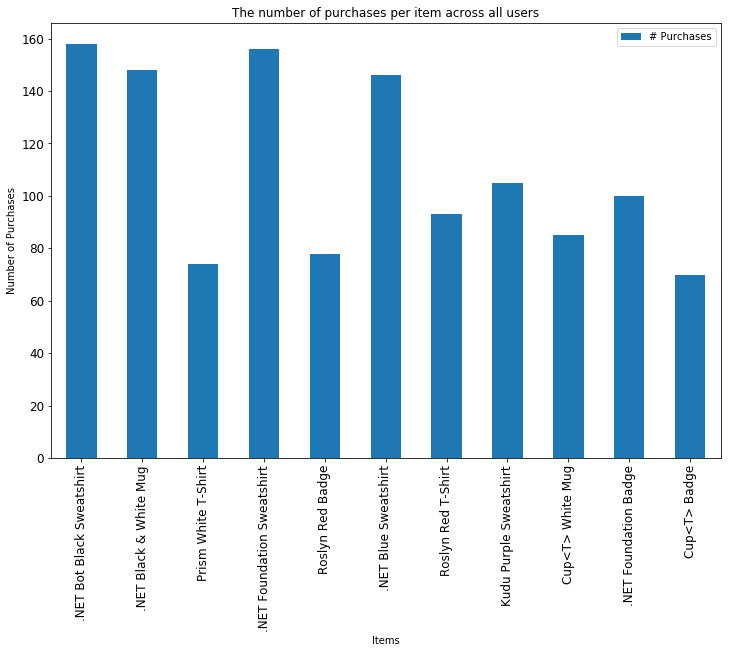

In [20]:
# Number of Purchases per item

labels =[".NET Bot Black Sweatshirt", ".NET Black & White Mug", "Prism White T-Shirt", ".NET Foundation Sweatshirt", "Roslyn Red Badge", ".NET Blue Sweatshirt", "Roslyn Red T-Shirt", "Kudu Purple Sweatshirt", "Cup<T> White Mug", ".NET Foundation Badge", "Cup<T> Badge"]


seed_purchases_per_item = pd.DataFrame({"Item": labels, "# Purchases": num_purchases})

bar1 = seed_purchases_per_item.plot(
    x='Item',
    y='# Purchases',
    kind='bar',
    figsize=(12, 8),
    title='The number of purchases per item across all users',
    fontsize=12,
)

bar1.set_xlabel("Items")
bar1.set_ylabel("Number of Purchases")

ave_purch_item = round( sum(num_purchases) / len(labels), 1)
print("\n\nThe average number of purchases per item is: " + str(ave_purch_item) +"\n\n")

### Here we can see that some products are more popular than others (Python Hoodie, 69 vs. .NET Hoodie, 43). Although in general we have a reasonably level purchases quantity across all products. This is good, as we won't have serious skew in our recommendations.

#### I could test for normality across the distribution of purchases and define what 'reasonably level is...' if I had more time.

560
560


The average number of purchases per user is: 2.2


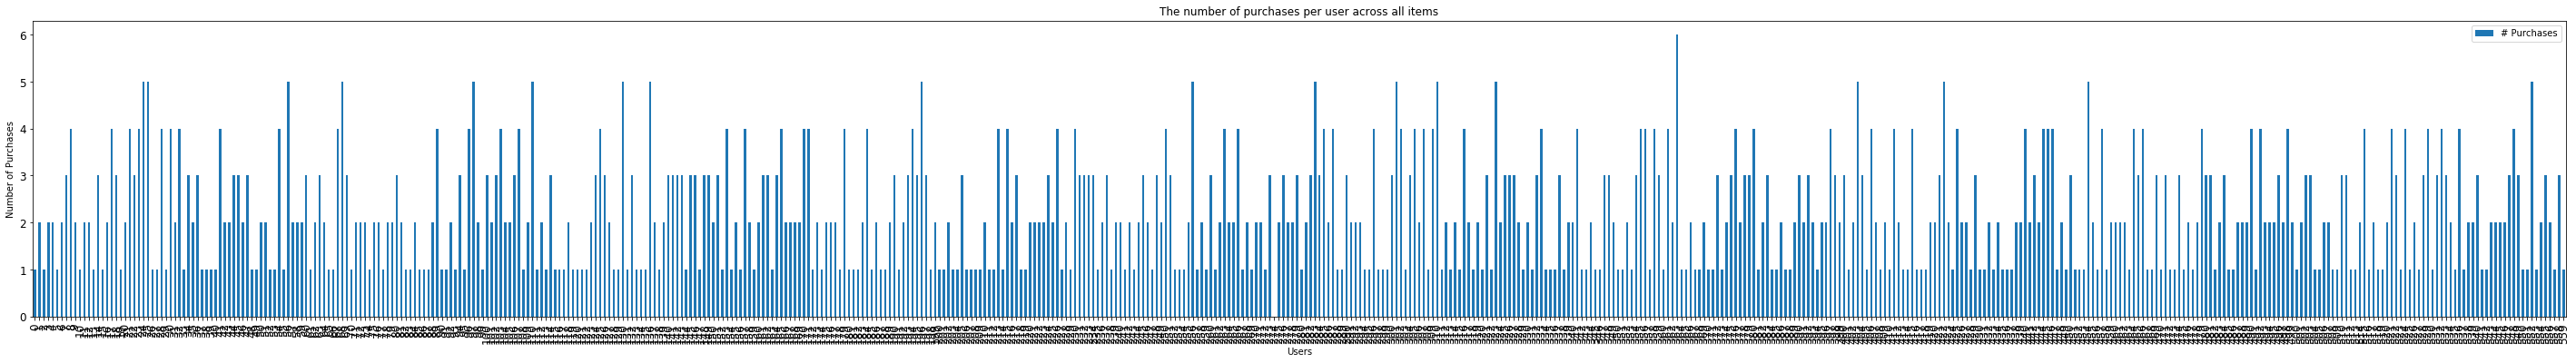

In [21]:
# Number of Item Purchases per User

num_users = seed.sum(axis=0)
num_users = num_users.tolist()

users = list(range(0, seed.shape[1]))

print(len(num_users))
print(len(users))


seed_purchases_per_user = pd.DataFrame({"Users": users, "# Purchases": num_users})

bar2 = seed_purchases_per_user.plot(
    x='Users',
    y='# Purchases',
    kind='bar',
    figsize=(50, 6),
    title='The number of purchases per user across all items',
    fontsize=12,
)

bar2.set_xlabel("Users")
bar2.set_ylabel("Number of Purchases")

ave_purch_user = round( sum(num_users) / len(users), 1)
print("\n\nThe average number of purchases per user is: " + str(ave_purch_user))


### What can we say about this data?

## Compute Item Similarity - Train KNN Model for item-based collaborative filtering

In [22]:
seed_pivot = seed
seed_matrix = csr_matrix(seed)


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute') # How does this work?
model_knn.fit(seed) # How does this work?

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

#### Can we visualise these interactions some how?

In [0]:
### HOW?

## Calculate the most appropriate recommendations for the basket

In [0]:
def basket_rec(listing):
  
  ids = {
      ".NET Bot Black Sweatshirt": 0,
      ".NET Black & White Mug": 1,
      "Prism White T-Shirt": 2,
      ".NET Foundation Sweatshirt": 3,
      "Roslyn Red Badge": 4,
      ".NET Blue Sweatshirt": 5,
      "Roslyn Red T-Shirt": 6,
      "Kudu Purple Sweatshirt": 7,
      "Cup<T> White Mug": 8,
      ".NET Foundation Badge": 9,
      "Cup<T> Badge": 10
  }
  
  
  temp = []
  for item in listing:
    temp.append(ids[item])
  listing = temp
  
  
  # Keep a track of which items are the best to recommend
  track_keys = []
  track_values = [] # Having a split dictionary like this prevents values from being overwritten as duplicates are added to the dictionary

  for item in listing:
    query_index = item
    distances, indices = model_knn.kneighbors(seed.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 9) # How does this work?
    # n_neighbours = 4 - returns the 3 nearest neighbours, plus itself

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(seed_pivot.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, seed_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

        track_values.append(distances.flatten()[i]) # Keep a track of all the distances from the 3 nearest neighbours
        track_keys.append(indices.flatten()[i]) # Keep a track of all the indices linked to the distances from the 3 nearest neighours


    print('\n\n\n')
    
    
  # Visualising the distances
  rec_distances = pd.DataFrame({"Items": track_keys, "Distances": track_values})

  bar3 = rec_distances.plot(
      x='Items',
      y='Distances',
      kind='bar',
      figsize=(12, 8),
      title='The distances between the basket items and all other items',
      fontsize=12,
  )

  bar3.set_xlabel("Items")
  bar3.set_ylabel("Distances")
  
  
  
  def find_label(value):
    return track_keys[track_values.index(value)]
    # for a given value (cosine similariy to basket item), return the unique index referring to an item {0: .NET Mug, 1: .NET Sheet, 2: .NET Hoodie, 3: Java Mug, 4: Java Sheet, 5: Java Hoodie, 6: Python Mug, 7: Python Sheet, 8: Python Hoodie}

    
    
  # Remove all items already in the basket from both lists
  # find the lowest (if it is not is the basket or rec), append to rec - delete key and value from lists. Repeat until rec.length = 3.
  rec = []
  recName = []
  while len(rec) < 3:
      if (find_label(min(track_values)) in rec or find_label(min(track_values)) in listing):
        track_keys.remove(find_label(min(track_values)))
        track_values.remove(min(track_values))
      else:
        rec.append(find_label(min(track_values)))
        recName.append((seed_pivot.index[find_label(min(track_values))], min(track_values))) # (Name, distance)
        
        
  print(rec)
  print(recName)
  print('\n\n\n')
  
  
  print(track_keys)
  print(track_values)
  
  import statistics
  sigma = statistics.stdev(track_values)
  mu = sum(track_values) / len(track_values)
  standard = [(i - mu) / sigma for i in track_values]
  print(standard)
  print(mu)
  print(sigma)
  

Recommendations for  Prism White T-Shirt:

1:  Rosyln Red T-Shirt, with distance of 0.7287399526549454:
2:  Roslyn Red Badge, with distance of 0.9374217282097801:
3:  Kudu Purple Sweatshirt, with distance of 0.9667323158359208:
4:  Cup<T> White Mug, with distance of 0.987975348243903:
5:  .NET Blue Sweatshirt, with distance of 1.0:
6:  .NET Foundation Badge, with distance of 1.0:
7: .NET Bot Black Sweatshirt, with distance of 1.0:
8:  .NET Foundation Sweatshirt, with distance of 1.0:




Recommendations for  Cup<T> Badge:

1:  Roslyn Red Badge, with distance of 0.7391797345213494:
2:  Cup<T> White Mug, with distance of 0.7494119944837059:
3:  .NET Foundation Badge, with distance of 0.7609542781331213:
4:  Rosyln Red T-Shirt, with distance of 0.9646691877136969:
5:  .NET Blue Sweatshirt, with distance of 0.971652664524308:
6:  .NET Black & White Mug, with distance of 0.9903685733933822:
7: .NET Bot Black Sweatshirt, with distance of 0.9907232268652586:
8:  Prism White T-Shirt, with dist

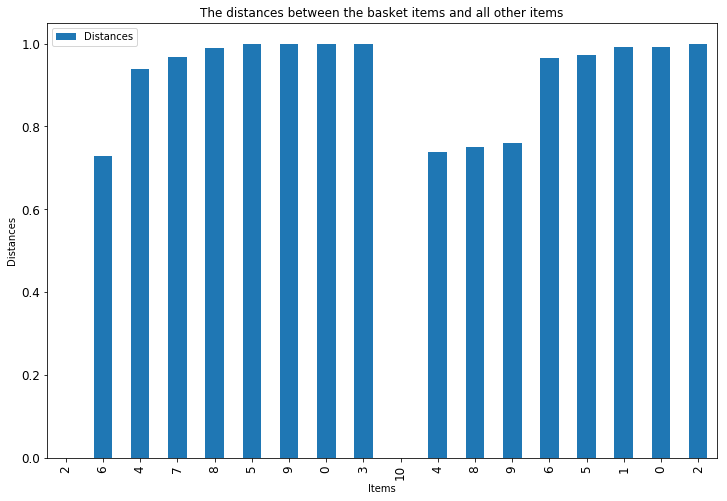

In [27]:
basket_rec(["Prism White T-Shirt", "Cup<T> Badge"]) 

# Pass in an array of the unique index positions of each item in the basket {0: .NET Mug, 1: .NET Sheet, 2: .NET Hoodie, 3: Java Mug, 4: Java Sheet, 5: Java Hoodie, 6: Python Mug, 7: Python Sheet, 8: Python Hoodie}
# Return an array of 3 unique index positions for the items to be recommended

# Extend to return tuples with the probabilities - softmax/sigmoid... (plot these tuples?) - items that would get recommended twice or more should have an unusually high rating...

In [0]:
# Here we can see that each item is strongly linked to 4 items, with a weak/no link to each of the remaining 4